In [51]:
# Import comet_ml at the top of your file, before sklearn!
from comet_ml import Experiment
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, make_scorer, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import StratifiedKFold
import seaborn as sn
import numpy as np

Read the last version of the data

In [52]:
df = pd.read_csv('tidyData_fe4.csv')

df

,Unnamed: 0,gamePk,homeTeam,period,periodType,periodTime,periodTimeRemaining,dateTime,teamId,teamName,...,coor_x_last_event,coor_y_last_event,time_last_event,distance_last_event,is_rebound,Change in shot angle,Speed,power_play_time,n_friend,n_oppose
0,0,2017020495,Vancouver Canucks,1,REGULAR,00:13,19:47,2017-12-16T03:08:32Z,23,Vancouver Canucks,...,0.0,0.0,13.0,78.102497,False,0.000000,0.000000,0,5,5
1,1,2017020495,Vancouver Canucks,1,REGULAR,00:14,19:46,2017-12-16T03:08:41Z,23,Vancouver Canucks,...,-78.0,4.0,1.0,5.000000,True,-0.348771,5.000000,0,5,5
2,2,2017020495,Vancouver Canucks,1,REGULAR,00:44,19:16,2017-12-16T03:09:40Z,23,Vancouver Canucks,...,-69.0,22.0,29.0,25.079872,True,-0.099669,0.864823,29,5,4
3,3,2017020495,Vancouver Canucks,1,REGULAR,01:20,18:40,2017-12-16T03:10:50Z,23,Vancouver Canucks,...,0.0,0.0,36.0,69.921384,False,0.000000,1.942261,0,5,5
4,4,2017020495,Vancouver Canucks,1,REGULAR,02:08,17:52,2017-12-16T03:12:03Z,23,Vancouver Canucks,...,-64.0,36.0,3.0,45.221676,True,-0.757420,15.073892,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385071,385071,2016030153,Nashville Predators,4,OVERTIME,12:06,07:54,2017-04-18T05:01:24Z,16,Chicago Blackhawks,...,55.0,-20.0,6.0,55.362442,True,0.817116,9.227074,0,5,5
385072,385072,2016030153,Nashville Predators,4,OVERTIME,13:56,06:04,2017-04-18T05:03:14Z,18,Nashville Predators,...,-57.0,-28.0,102.0,29.206164,True,-0.926397,0.286335,0,5,5
385073,385073,2016030153,Nashville Predators,4,OVERTIME,15:07,04:53,2017-04-18T05:05:35Z,18,Nashville Predators,...,-69.0,22.0,2.0,41.677332,True,0.360879,20.838666,0,5,5
385074,385074,2016030153,Nashville Predators,4,OVERTIME,15:24,04:36,2017-04-18T05:06:20Z,16,Chicago Blackhawks,...,-44.0,11.0,12.0,75.643903,True,-0.320740,6.303659,0,5,5


Split the training set(2016-2017,2017-2018,2018-2019,2019-2020)

In [53]:
df['year'] = df['gamePk'].astype(str).str[:4].astype(int)
df['gameType'] = df['gamePk'].astype(str).str[4:6]
train = df[(df['year'].isin([2016, 2017, 2018, 2019])) & (df['gameType'] == '02')]
test_regular = df[(df['year'].isin([2020])) & (df['gameType'] == '02')]
test_playoffs = df[(df['year'].isin([2020])) & (df['gameType'] == '03')]
train

,Unnamed: 0,gamePk,homeTeam,period,periodType,periodTime,periodTimeRemaining,dateTime,teamId,teamName,...,time_last_event,distance_last_event,is_rebound,Change in shot angle,Speed,power_play_time,n_friend,n_oppose,year,gameType
0,0,2017020495,Vancouver Canucks,1,REGULAR,00:13,19:47,2017-12-16T03:08:32Z,23,Vancouver Canucks,...,13.0,78.102497,False,0.000000,0.000000,0,5,5,2017,02
1,1,2017020495,Vancouver Canucks,1,REGULAR,00:14,19:46,2017-12-16T03:08:41Z,23,Vancouver Canucks,...,1.0,5.000000,True,-0.348771,5.000000,0,5,5,2017,02
2,2,2017020495,Vancouver Canucks,1,REGULAR,00:44,19:16,2017-12-16T03:09:40Z,23,Vancouver Canucks,...,29.0,25.079872,True,-0.099669,0.864823,29,5,4,2017,02
3,3,2017020495,Vancouver Canucks,1,REGULAR,01:20,18:40,2017-12-16T03:10:50Z,23,Vancouver Canucks,...,36.0,69.921384,False,0.000000,1.942261,0,5,5,2017,02
4,4,2017020495,Vancouver Canucks,1,REGULAR,02:08,17:52,2017-12-16T03:12:03Z,23,Vancouver Canucks,...,3.0,45.221676,True,-0.757420,15.073892,0,5,5,2017,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379635,379635,2016020295,Nashville Predators,3,REGULAR,11:09,08:51,2016-11-24T03:22:15Z,18,Nashville Predators,...,2.0,31.780497,True,1.115501,15.890249,0,5,5,2016,02
379636,379636,2016020295,Nashville Predators,3,REGULAR,11:27,08:33,2016-11-24T03:23:21Z,25,Dallas Stars,...,18.0,90.249654,False,0.000000,5.013870,0,5,5,2016,02
379637,379637,2016020295,Nashville Predators,3,REGULAR,16:08,03:52,2016-11-24T03:30:46Z,25,Dallas Stars,...,6.0,114.017543,True,-1.437372,19.002924,0,5,5,2016,02
379638,379638,2016020295,Nashville Predators,3,REGULAR,18:44,01:16,2016-11-24T03:36:11Z,25,Dallas Stars,...,4.0,8.944272,True,-0.377844,2.236068,0,5,5,2016,02


Extract the features and the label

In [54]:
f_train = train[['period', 'x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'shotType', 'last_event_type', 'coor_x_last_event', 'coor_y_last_event',
                 'time_last_event', 'distance_last_event', 'is_rebound', 'Change in shot angle', 'Speed', 'power_play_time', 'n_friend', 'n_oppose']]
f_train['is_rebound'] = f_train['is_rebound'].astype(int)
f_train

C:\Users\Shilong Zhou\AppData\Local\Temp\ipykernel_23820\2349418554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_train['is_rebound'] = f_train['is_rebound'].astype(int)


,x-coordinate,y-coordinate,shot_distance,angle,coor_x_last_event,coor_y_last_event,distance_last_event,is_rebound,Change in shot angle,Speed,power_play_time,n_friend,n_oppose
0,-78.0,4.0,11.704700,0.348771,0.0,0.0,78.102497,0,0.000000,0.000000,0,5,5
1,-81.0,0.0,8.000000,0.000000,-78.0,4.0,5.000000,1,-0.348771,5.000000,0,5,5
2,-79.0,-1.0,10.049876,-0.099669,-69.0,22.0,25.079872,1,-0.099669,0.864823,29,5,4
3,-67.0,20.0,29.732137,0.737815,0.0,0.0,69.921384,0,0.000000,1.942261,0,5,5
4,-38.0,-1.0,51.009803,-0.019605,-64.0,36.0,45.221676,1,-0.757420,15.073892,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379635,81.0,5.0,9.433981,0.558599,50.0,12.0,31.780497,1,1.115501,15.890249,0,5,5
379636,-84.0,33.0,33.376639,1.420425,0.0,0.0,90.249654,0,0.000000,5.013870,0,5,5
379637,-30.0,-1.0,59.008474,-0.016948,84.0,1.0,114.017543,1,-1.437372,19.002924,0,5,5
379638,-77.0,-5.0,13.000000,-0.394791,-81.0,3.0,8.944272,1,-0.377844,2.236068,0,5,5


In [55]:
l_train = train['isgoal']
l_train

0         0
1         0
2         1
3         0
4         0
         ..
379635    1
379636    0
379637    0
379638    1
379639    1
Name: isgoal, Length: 305814, dtype: int64

Spilt train set into train and validation set

In [56]:
x_train, x_val, y_train, y_val = train_test_split(f_train.fillna(0),l_train, test_size=0.25,random_state=10, shuffle = True, stratify=l_train.to_numpy())

<Axes: xlabel='isgoal', ylabel='count'>

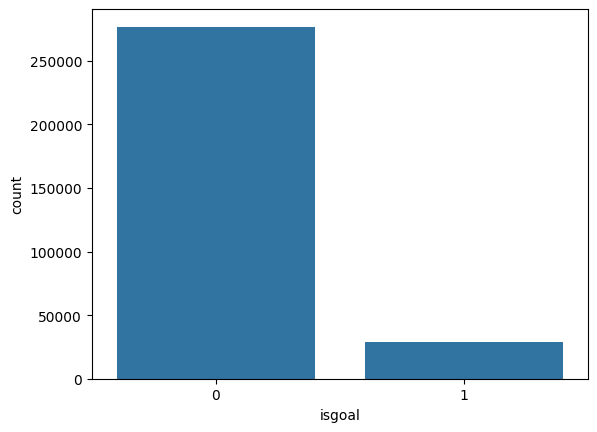

In [57]:
sn.countplot(x = 'isgoal', data = train)

KNN Pipeline

In [58]:
# Define preprocessing steps
numeric_features = make_column_selector(dtype_include='float')
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Create KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn_classifier)
])


Train model

In [59]:
# Define the parameter grid for Grid Search
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

# Use StratifiedKFold for cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use ROC-AUC as a scoring metric
scorer = make_scorer(roc_auc_score)

# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(f'Best Hyperparameters: {best_params}')

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_estimator, x_train, y_train, cv=cv_strategy, scoring=scorer, n_jobs=-1)
print(f'Cross-Validation ROC-AUC scores: {cv_scores}')
print(f'Mean CV ROC-AUC: {np.mean(cv_scores):.2f}')

# Fit the model with the best estimator on the training data
best_estimator.fit(x_train, y_train)

# Make predictions on the validation set
y_pred_val = best_estimator.predict(x_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {accuracy_val:.2f}')

# Print other metrics like classification report
print(classification_report(y_val, y_pred_val))

Best Hyperparameters: {'classifier__n_neighbors': 9, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Cross-Validation ROC-AUC scores: [0.51081786 0.5095766  0.51018838 0.51199966 0.51012174]
Mean CV ROC-AUC: 0.51
Validation Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     69196
           1       0.29      0.03      0.05      7258

    accuracy                           0.90     76454
   macro avg       0.60      0.51      0.50     76454
weighted avg       0.85      0.90      0.86     76454



I have chosen the KNN model, which is an instance-based learning method that predicts based on the distances between samples.

**Feature Selection**:
I selected a set of features for modeling, including coordinate information, shot distance, angle, etc.

**Training Data Split**:
I utilized a basic random splitting method.

**Hyperparameter Tuning and Cross-Validation**:
I employed Grid Search to adjust the hyperparameters of the KNN model, considering different numbers of neighbors, weightings, and distance metrics.

**Regularization**:
In the context of the KNN model, regularization is generally not applied as the model itself lacks parameters that need regularization.

**Explore More Novel Metrics for This Task**:
I used ROC-AUC and accuracy as performance metrics.